## *Does a job training program improve the earnings of disadvantaged workers?*

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble



# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

<h2>Introduction</h2>

<p><strong>Business Context.</strong> In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.</p>
<p><img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training"></p>
<p>The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.</p>
<p><strong>Business Problem.</strong> To evaluate <strong>whether the job training program <em>causes</em> the earnings of disadvantaged workers to go up</strong>.</p>
<p><strong>Analytical Context.</strong> Exploring the topic of causal inference. Will show the importance of covariate balance and explore how to perform matching to get this balance. Will leverage a lot of the new classification models learned for this purpose.</p>

<h2>Examining the data</h2>
<p>The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is <code>re78</code> in which we want to know if there was an increase in earnings in 1978:</p>
<ol>
<li><strong>age</strong>: age in years</li>
<li><strong>educ</strong>: years of schooling</li>
<li><strong>black</strong>: indicator variable for blacks</li>
<li><strong>hisp</strong>: indicator variable for Hispanics</li>
<li><strong>married</strong>: indicator variable for martial status</li>
<li><strong>nodegr</strong>: indicator variable for high school diploma</li>
<li><strong>re74</strong>: real earnings in 1974</li>
<li><strong>re75</strong>: real earnings in 1975</li>
<li><strong>re78</strong>: real earnings in 1978 - this is the outcome of interest</li>
<li><strong>treat</strong>: an indicator variable for treatment status</li>
</ol>

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.tail()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000
PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100
PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000
PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713
PSID429,0,16,9,0,0,0,1,0.0,0.0,1495.4590


<h3>Step 1:</h3>
<h4>1.1</h4>
<p>Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?</p>

**Answer.**

In [3]:
# Drop unnecessary index column
lalonde_df = lalonde_df.drop(columns=["Unnamed: 0"], errors='ignore')

# Compute summary statistics
summary_stats = lalonde_df.describe()
print("Summary Statistics:\n", summary_stats)

# Calculate percentage of population with a decrease in income from 1974 to 1975
decrease_count = (lalonde_df["re75"] < lalonde_df["re74"]).sum()
total_count = len(lalonde_df)
percentage_decrease = (decrease_count / total_count) * 100

print(f"\nPercentage of individuals with decreased income from 1974 to 1975: {percentage_decrease:.2f}%")

# Average income trends
time_period_means = lalonde_df[['re74', 're75', 're78']].mean()
print("\nAverage income over the years:")
print(time_period_means)

Summary Statistics:
             treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  614.000000    614.000000    614.000000    614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483  
std      0.483119   6477.964479   3295.679043   7470.730792  
m

-------

<h4>1.2</h4>
<p>What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?</p>
<p><strong>Note:</strong> Remember that the <em>treatment and control groups</em> correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  <code>treat</code> column.</p>

**Answer.**

In [4]:
from scipy.stats import ttest_ind

# Calculate percentage of workers in the treatment group
treatment_group = (lalonde_df["treat"] == 1 ).sum()
total_treatment = len(lalonde_df)
treatment_percentage = (treatment_group / total_treatment) * 100
control_group = (lalonde_df["treat"] == 0 ).sum()


print(f"\nPercentage of workers in the treatment group: {treatment_percentage:.2f}%")


# Splitting data into treatment and control groups
treatment_group_df = lalonde_df[lalonde_df['treat'] == 1]  # DataFrame for treatment group
control_group_df = lalonde_df[lalonde_df['treat'] == 0]  # DataFrame for control group

# Difference in means and medians of re78 between groups
mean_diff = treatment_group_df['re78'].mean() - control_group_df['re78'].mean()
median_diff = treatment_group_df['re78'].median() - control_group_df['re78'].median()

print(f"\nDifference in means of re78 (treatment - control): {mean_diff:.2f}")
print(f"Difference in medians of re78 (treatment - control): {median_diff:.2f}")

# Statistical significance test (t-test)
t_stat, p_value = ttest_ind(treatment_group_df['re78'], control_group_df['re78'], equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")


Percentage of workers in the treatment group: 30.13%

Difference in means of re78 (treatment - control): -635.03
Difference in medians of re78 (treatment - control): -743.20

T-test results: t-statistic = -0.94, p-value = 0.3491


-------

<h4>1.3</h4>
<p>Does your previous result mean that the treatment had a negative impact? Why or why not?</p>

**Answer.**

it means that the workers in the control group made more earings than the workers in the treatment group.

-------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?</p>

**Answer.**

In [5]:
print(treatment_group_df.columns)
print(control_group_df.columns)


Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')
Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')


In [6]:
# Define function to calculate SMD
def compute_smd(feature):
    mean_treat = treatment_group_df[feature].mean()
    mean_control = control_group_df[feature].mean()
    var_treat = treatment_group_df[feature].var()
    var_control = control_group_df[feature].var()
    
    smd = (mean_treat - mean_control) / np.sqrt((var_treat + var_control) / 2)
    return smd

# Select numerical covariates for SMD calculation (excluding the outcome and treatment indicator)
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

# Compute SMD for all covariates
smd_results = {cov: compute_smd(cov) for cov in covariates}

# Convert results into a DataFrame
smd_df = pd.DataFrame(smd_results.items(), columns=['Covariate', 'SMD'])

# Identify imbalanced features
smd_df['Imbalanced'] = smd_df['SMD'].abs() > 0.2

# Display results
print(smd_df)

  Covariate       SMD  Imbalanced
0       age -0.241904        True
1      educ  0.044755       False
2     black  1.667719        True
3    hispan -0.276940        True
4   married -0.719492        True
5  nodegree  0.235048        True
6      re74 -0.595752        True
7      re75 -0.287002        True


-------

<h4>2.2</h4>
<p>Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.</p>

**Answer.**

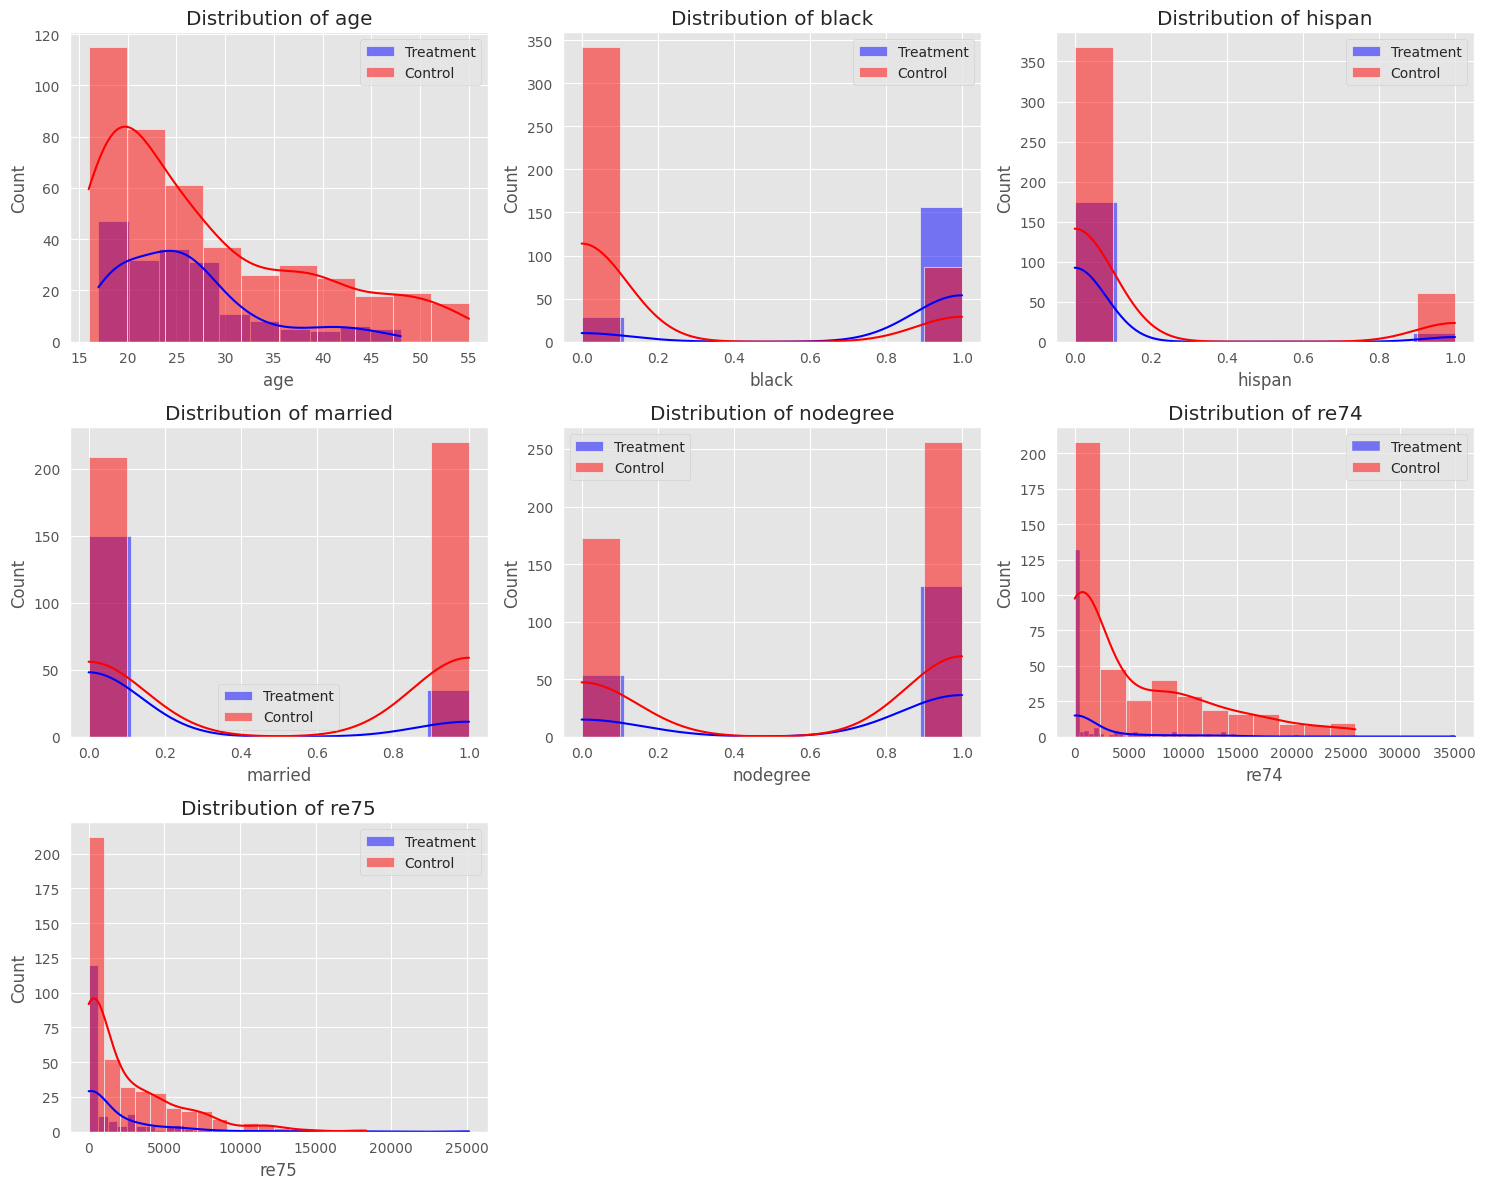

In [7]:
# List of imbalanced covariates
imbalanced_covariates = ['age', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

# Set up plot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Plot histograms for each imbalanced covariate
for i, cov in enumerate(imbalanced_covariates):
    sns.histplot(treatment_group_df[cov], label="Treatment", color="blue", kde=True, alpha=0.5, ax=axes[i])
    sns.histplot(control_group_df[cov], label="Control", color="red", kde=True, alpha=0.5, ax=axes[i])
    
    axes[i].set_title(f"Distribution of {cov}")
    axes[i].legend()

# Remove extra subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


-------

<h2>Propensity score matching using logistic regression</h2>

<p>In order to balance the covariates of the control and treatment groups, we will use <strong>matching</strong>. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.</p>
<p>In Case 7.5 we used the <em>Euclidean distance</em> on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.</p>
<p>We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the <strong>propensity score</strong> helps us do the matching on select features in an efficient way. The key idea is that <em>the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results</em>. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:</p>
<p>$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)</p>
<p>As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.</p>

<h3>Exercise 3:</h3>
<h4>3.1</h4>
<p>Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. How would you interpret the predicted values output by the model? </p>

**Answer.**

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Combine both groups into a single dataset
data = pd.concat([treatment_group_df, control_group_df], ignore_index=True)

# Define X (covariates) and y (treatment indicator)
X = data[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
y = data['treat']  # Using 'treat' instead of 'treatment'

# Standardize numerical covariates
scaler = StandardScaler()
X[['age', 'educ', 're74', 're75']] = scaler.fit_transform(X[['age', 'educ', 're74', 're75']])

# Fit logistic regression
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict propensity scores
data['propensity_score'] = log_reg.predict_proba(X)[:, 1]

# Display the first few rows
print(data[['treat', 'propensity_score']].head())

   treat  propensity_score
0      1          0.618651
1      1          0.209792
2      1          0.666818
3      1          0.757360
4      1          0.688890


-------

<h4>3.2</h4>
<p>Use <code>.predict()</code>  to obtain the propensity scores of individuals in our dataset. Save the the results with the name <code>pscore_logit</code> (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.</p>

**Answer.**

   treat  pscore_logit
0      1      0.618651
1      1      0.209792
2      1      0.666818
3      1      0.757360
4      1      0.688890


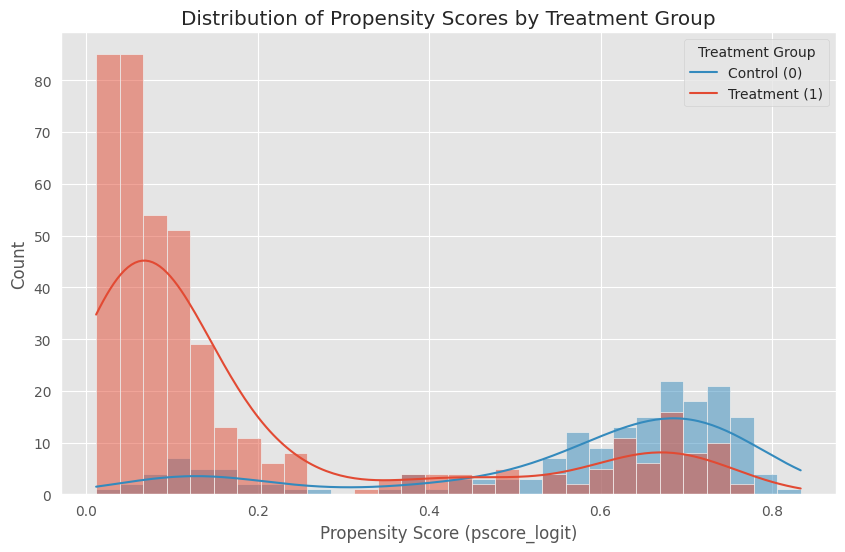

In [9]:
# Compute propensity scores using predict_proba
data['pscore_logit'] = log_reg.predict_proba(X)[:, 1]  # Save as 'pscore_logit'

# Display the first few rows
print(data[['treat', 'pscore_logit']].head())

# Set figure size
plt.figure(figsize=(10,6))

# Plot histograms
sns.histplot(data=data, x='pscore_logit', hue='treat', kde=True, bins=30, alpha=0.5)

# Labels and title
plt.xlabel("Propensity Score (pscore_logit)")
plt.ylabel("Count")
plt.title("Distribution of Propensity Scores by Treatment Group")
plt.legend(title="Treatment Group", labels=["Control (0)", "Treatment (1)"])
plt.show()

-------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

<h3>Exercise 4 :</h3>
<p>In this exercise, we will use the <code>sklearn.neighbors</code> function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors"><code>NearestNeighbors</code></a> to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.</p>
<h4>4.1</h4>
<p>Separate the propensity scores <code>pscore_logit</code> found in Exercise 3 for treatment and control groups. Call these <code>treat_pscores</code> and <code>control_pscores</code> respectively. Use the <code>control_pscores</code> to train a $k$-NN algorithm with $k=5$.</p>
<p><strong>Hint:</strong> Load the model using <code>knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')</code>. You may want to reshape the control scores using <code>control_pscores.reshape(-1,1)</code>.</p>

**Answer.**

In [10]:
from sklearn.neighbors import NearestNeighbors

# Separate propensity scores
treat_pscores = data[data['treat'] == 1]['pscore_logit'].values  # Treated group scores
control_pscores = data[data['treat'] == 0]['pscore_logit'].values.reshape(-1, 1)  # Control scores reshaped

# Load the k-NN model (k=5, Euclidean distance)
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')

# Fit the model using control group's propensity scores
knn.fit(control_pscores)

# Reshape treat_pscores for searching
treat_pscores_reshaped = treat_pscores.reshape(-1, 1)

# Find the indices of the 5 closest control subjects for each treated subject
distances, indices = knn.kneighbors(treat_pscores_reshaped)

# Display first few matches
print("Indices of matched control subjects:\n", indices[:5])
print("Distances to matched control subjects:\n", distances[:5])

Indices of matched control subjects:
 [[156 190 418 367 386]
 [299  65 198 338 426]
 [369 188 380 354 325]
 [225 195 117 387 230]
 [133 139 217 276 371]]
Distances to matched control subjects:
 [[0.00098238 0.00202509 0.0030805  0.00941122 0.00948711]
 [0.00157168 0.00300874 0.00629718 0.00925472 0.01060299]
 [0.00335011 0.00415632 0.00462855 0.00622116 0.00638571]
 [0.00073811 0.00969469 0.01439648 0.02017997 0.02267511]
 [0.00140464 0.00454015 0.00510439 0.00662339 0.0070169 ]]


-------

<h4>4.2</h4>
<p>Find the indices of the five nearest neighbors using the method <code>.kneighbors()</code> applied to <code>treat_pscores</code>. </p>

**Answer.**

In [11]:
 # Reshape treat_pscores for searching
treat_pscores_reshaped = treat_pscores.reshape(-1, 1)

# Find the indices of the 5 nearest control subjects
distances, indices = knn.kneighbors(treat_pscores_reshaped)

# Display first few results
print("Indices of the 5 nearest control subjects:\n", indices[:5])
print("Distances to the matched control subjects:\n", distances[:5])  


Indices of the 5 nearest control subjects:
 [[156 190 418 367 386]
 [299  65 198 338 426]
 [369 188 380 354 325]
 [225 195 117 387 230]
 [133 139 217 276 371]]
Distances to the matched control subjects:
 [[0.00098238 0.00202509 0.0030805  0.00941122 0.00948711]
 [0.00157168 0.00300874 0.00629718 0.00925472 0.01060299]
 [0.00335011 0.00415632 0.00462855 0.00622116 0.00638571]
 [0.00073811 0.00969469 0.01439648 0.02017997 0.02267511]
 [0.00140464 0.00454015 0.00510439 0.00662339 0.0070169 ]]


-------

<h4>4.3</h4>
<p>Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of <code>DataFrames</code>, each with $185$ rows from the <code>lalonde_df</code>. The first should correspond to the treatment group and the second should correspond to the matched control group.</p>

**Answer.**

In [12]:
# Get the closest (first) control match for each treated individual
closest_control_indices = indices[:, 0]  # Selecting the nearest neighbor (first column)

# Extract treatment group (all individuals where treat == 1)
matched_treatment_df = lalonde_df[lalonde_df['treat'] == 1].reset_index(drop=True)

# Extract the corresponding matched control individuals
matched_control_df = lalonde_df[lalonde_df['treat'] == 0].iloc[closest_control_indices].reset_index(drop=True)

print("Matched Treatment Group Shape:", matched_treatment_df.shape)  # Should be (185, #columns)
print("Matched Control Group Shape:", matched_control_df.shape)  # Should also be (185, #columns)




Matched Treatment Group Shape: (185, 10)
Matched Control Group Shape: (185, 10)


In [13]:
print(matched_treatment_df.columns)
print(matched_control_df.columns)


Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')
Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')


-------

<h3>Propensity score distribution plot after matching</h3>
<p>Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.</p>

<h3>Exercise 5 :</h3>
<p>Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.</p>

**Answer.**

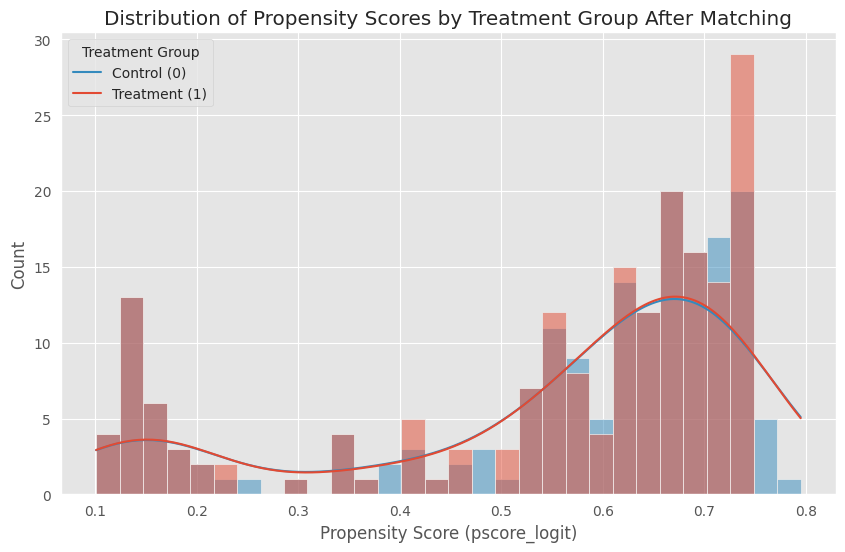

In [14]:
# Ensure 'lalonde_df' includes the 'pscore_logit' column
if 'pscore_logit' not in lalonde_df.columns:
    lalonde_df = data.copy()

# Define your covariates (X) and treatment indicator (y)
X = lalonde_df.drop(columns=['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75'])  # Replace 'outcome' with your actual outcome variable name
y = lalonde_df['treat']

# Initialize and fit the logistic regression model
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X, y)

# Compute propensity scores using predict_proba
lalonde_df['pscore_logit'] = log_reg.predict_proba(X)[:, 1]

# Separate propensity scores
treat_pscores = lalonde_df[lalonde_df['treat'] == 1]['pscore_logit'].values.reshape(-1, 1)
control_pscores = lalonde_df[lalonde_df['treat'] == 0]['pscore_logit'].values.reshape(-1, 1)

# Initialize the k-NN model (k=1 for 1:1 matching)
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')

# Fit the model using control group's propensity scores
knn.fit(control_pscores)

# Find the indices of the closest control subjects for each treated subject
distances, indices = knn.kneighbors(treat_pscores)

# Get the closest control match for each treated individual
closest_control_indices = indices.flatten()  # Flatten to convert to 1D array

# Extract treatment group (all individuals where treat == 1)
matched_treatment_df = lalonde_df[lalonde_df['treat'] == 1].reset_index(drop=True)

# Extract the corresponding matched control individuals
matched_control_df = lalonde_df[lalonde_df['treat'] == 0].iloc[closest_control_indices].reset_index(drop=True)



# Combine matched data for plotting
matched_data = pd.concat([matched_treatment_df, matched_control_df], ignore_index=True)

# Set figure size
plt.figure(figsize=(10, 6))

# Plot histograms
sns.histplot(data=matched_data, x='pscore_logit', hue='treat', kde=True, bins=30, alpha=0.5)

# Labels and title
plt.xlabel("Propensity Score (pscore_logit)")
plt.ylabel("Count")
plt.title("Distribution of Propensity Scores by Treatment Group After Matching")
plt.legend(title="Treatment Group", labels=["Control (0)", "Treatment (1)"])
plt.show()


-------

<h3>Exercise 6 :</h3>

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [15]:
# Compute means of each covariate after matching
means_treatment_after = matched_data[matched_data['treat'] == 1].mean()
means_control_after = matched_data[matched_data['treat'] == 0].mean()

# Compute variances of each covariate before matching
variances_treatment_before = data[data['treat'] == 1].var()
variances_control_before = data[data['treat'] == 0].var()

# Compute ASMD for each covariate
asmd = (means_treatment_after - means_control_after) / np.sqrt((variances_treatment_before + variances_control_before) / 2)

# Show ASMD values
print(asmd)



treat                    inf
age                 0.271075
educ               -0.065671
black               0.014076
hispan              0.018094
married             0.156224
nodegree            0.034224
re74               -0.040531
re75                0.022951
re78                0.235129
propensity_score    0.003434
pscore_logit        0.001690
dtype: float64


-------

<h3>Exercise 7 :</h3>
<p>Estimate the average effect of treatment on <font color='red'> wages (<code>re78</code>) </font> after matching. What do you conclude?</p>

**Answer.**

In [16]:
# Compute ATT (Difference in Mean re78 between Treatment and Control)
att = matched_data[matched_data['treat'] == 1]['re78'].mean() - matched_data[matched_data['treat'] == 0]['re78'].mean()

print(f"Estimated ATT on re78: {att}")


Estimated ATT on re78: 1783.7353152432443


Since att > 0, the treatment group earned more on average than the control group after matching.


-------

<h2>Propensity score matching using decision trees and random forests</h2>

<h3>Exercise 8 :</h3>
<p>To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.</p>

<h4>8.1</h4>
<p>Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. Use the <code>sklearn.tree</code> function <code>DecisionTreeRegressor(max_depth=4)</code> and call the new propensity scores <code>pscore_tree</code>.</p>

**Answer.**

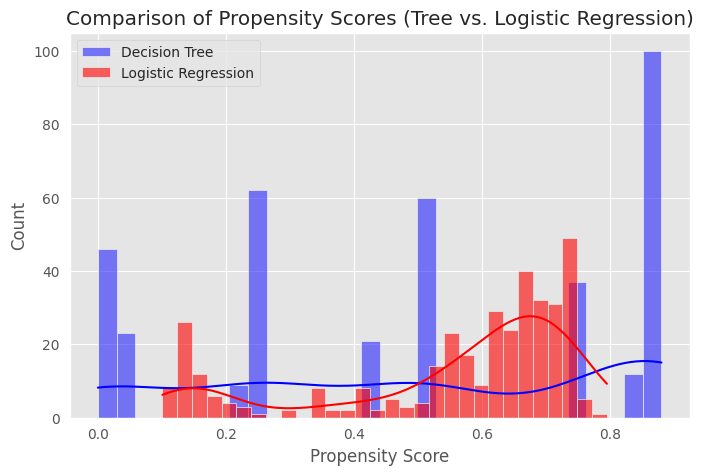

In [17]:
from sklearn.tree import DecisionTreeRegressor

# Define covariates (exclude 're78' and 'treatment' from predictors)
covariates = matched_data.drop(columns=['re78', 'treat'])

# Define target variable (treatment assignment)
treatment = matched_data['treat']

# Initialize Decision Tree Regressor with max_depth=4
tree_model = DecisionTreeRegressor(max_depth=4, random_state=1337)

# Fit model
tree_model.fit(covariates, treatment)

# Predict propensity scores
matched_data['pscore_tree'] = tree_model.predict(covariates)

plt.figure(figsize=(8,5))
sns.histplot(matched_data['pscore_tree'], bins=30, kde=True, color='blue', label='Decision Tree')
sns.histplot(matched_data['pscore_logit'], bins=30, kde=True, color='red', label='Logistic Regression', alpha=0.6)
plt.legend()
plt.title('Comparison of Propensity Scores (Tree vs. Logistic Regression)')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.show()


-------

<h4>8.2</h4>
<p>Plot the decision tree regressor using the code</p>
<div class="codehilite"><pre><span></span><code><span class="err">fig = plt.gcf()</span>
<span class="err">fig.set_size_inches(150, 100)</span>
<span class="err">tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)</span>
<span class="err">fig.savefig(&#39;tree.png&#39;)</span>
</code></pre></div>


<p>Replace <code>dt</code> with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)</p>

**Answer.**

In [18]:
covariates.head()

,age,educ,black,hispan,married,nodegree,re74,re75,propensity_score,pscore_logit
0,37,11,1,0,1,1,0.0,0.0,0.618651,0.599312
1,22,9,0,1,0,1,0.0,0.0,0.209792,0.197448
2,30,12,1,0,0,0,0.0,0.0,0.666818,0.647633
3,27,11,1,0,0,1,0.0,0.0,0.757360,0.734397
4,33,8,1,0,0,1,0.0,0.0,0.688890,0.672085


Propensity score for Hispanic individual: 0.42857142857142855
Propensity score for Black individual: 0.42857142857142855


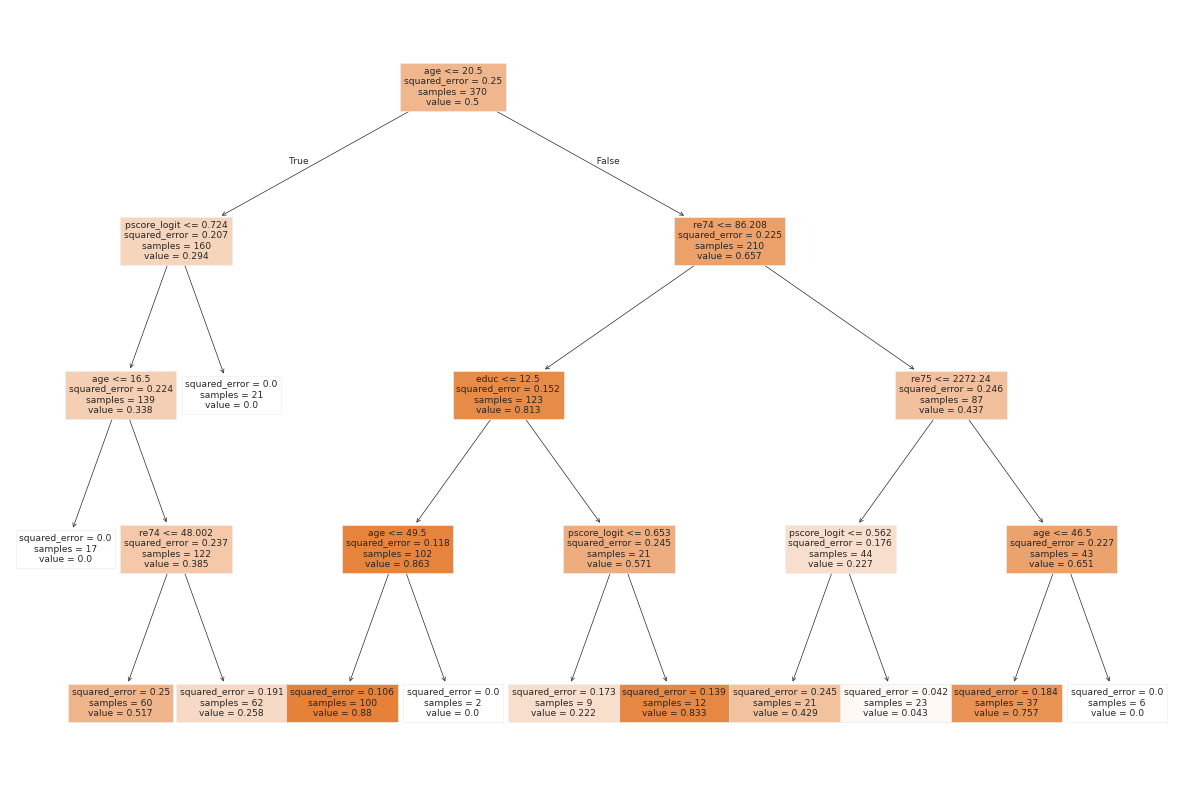

In [19]:
# Define the two individuals
individual_1 = {
    'age': 24,
    'educ': 0,  
    'black': 0,   
    'hispan': 1,
    'married':0,
    'nodegree':1,         
    're74': 20000       
}

individual_2 = {
    'age': 24,
    'educ': 0,  
    'black': 1,   
    'hispan': 0,
    'married':0,
    'nodegree':1,         
    're74': 20000       
}

# Convert them to a DataFrame (assuming the covariates columns exist)
individual_1_df = pd.DataFrame([individual_1])
individual_2_df = pd.DataFrame([individual_2])

# Apply the same preprocessing steps (e.g., one-hot encoding)
individual_1_encoded = pd.get_dummies(individual_1_df)
individual_2_encoded = pd.get_dummies(individual_2_df)

# Ensure both individuals have the same columns as your model
individual_1_encoded = individual_1_encoded.reindex(columns=covariates.columns, fill_value=0)
individual_2_encoded = individual_2_encoded.reindex(columns=covariates.columns, fill_value=0)


# Predict the propensity score for both individuals
pscore_individual_1 = tree_model.predict(individual_1_encoded)
pscore_individual_2 = tree_model.predict(individual_2_encoded)

print(f"Propensity score for Hispanic individual: {pscore_individual_1[0]}")
print(f"Propensity score for Black individual: {pscore_individual_2[0]}")


# Plot the decision tree
fig = plt.gcf()
fig.set_size_inches(15, 10)
tree.plot_tree(tree_model, filled=True, feature_names=covariates.columns)

# Save the figure
fig.savefig('tree.png')
plt.show()


-------

<h4>8.3</h4>
<p>Estimate the propensity scores now by using random forests. For the model, use the <code>sklearn.ensemble</code> function <code>RandomForestClassifier</code> with parameters <code>n_estimators=100, max_depth=4, random_state=42</code>. Then, use the method <code>predict_proba</code> to extract the propensity scores. Name the scores <code>pscore_forest</code>.</p>

**Answer.**

   pscore_forest
0       0.783955
1       0.766828
2       0.740342
3       0.866597
4       0.762052


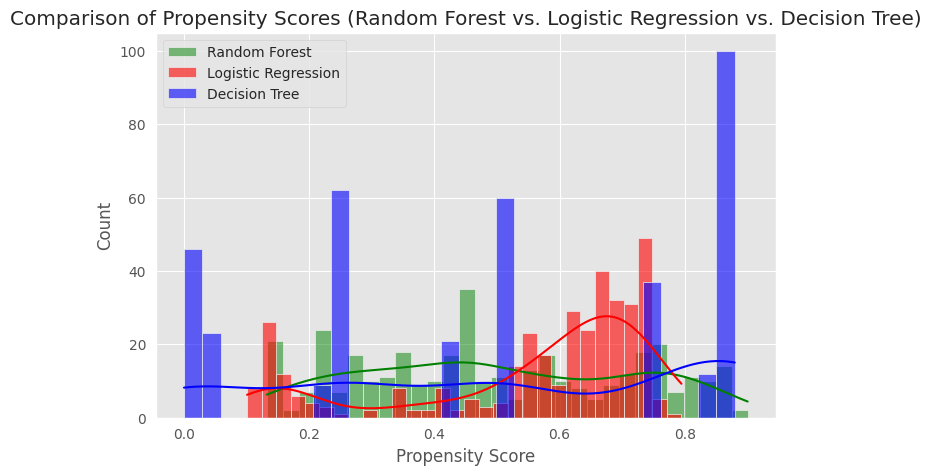

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with specified parameters
forest_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# Fit the Random Forest model
forest_model.fit(covariates, treatment)

# Get the predicted probabilities for the treatment class (class 1)
pscore_forest = forest_model.predict_proba(covariates)[:, 1]

# Add the propensity scores to the dataset
matched_data['pscore_forest'] = pscore_forest

# Display the first few rows of the propensity scores
print(matched_data[['pscore_forest']].head())

# Plot comparison of propensity scores
plt.figure(figsize=(8,5))
sns.histplot(matched_data['pscore_forest'], bins=30, kde=True, color='green', label='Random Forest')
sns.histplot(matched_data['pscore_logit'], bins=30, kde=True, color='red', label='Logistic Regression', alpha=0.6)
sns.histplot(matched_data['pscore_tree'], bins=30, kde=True, color='blue', label='Decision Tree', alpha=0.6)
plt.legend()
plt.title('Comparison of Propensity Scores (Random Forest vs. Logistic Regression vs. Decision Tree)')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.show()


-------

<h4>8.4</h4>
<p>Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model <em>seems</em> to do the best job?</p>

**Answer.**

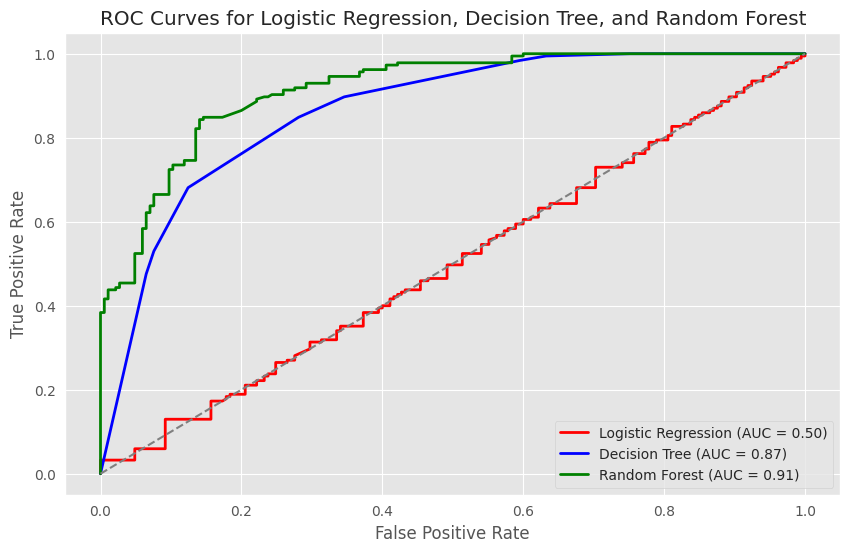

In [21]:
from sklearn.metrics import roc_curve, auc

pscore_logit = matched_data['pscore_logit']
pscore_tree = matched_data['pscore_tree']


# Compute ROC curve and AUC for each model
fpr_logit, tpr_logit, _ = roc_curve(treatment, pscore_logit)
fpr_tree, tpr_tree, _ = roc_curve(treatment, pscore_tree)
fpr_forest, tpr_forest, _ = roc_curve(treatment, pscore_forest)

roc_auc_logit = auc(fpr_logit, tpr_logit)
roc_auc_tree = auc(fpr_tree, tpr_tree)
roc_auc_forest = auc(fpr_forest, tpr_forest)

# Plot ROC curves
plt.figure(figsize=(10,6))

# Plot ROC for Logistic Regression
plt.plot(fpr_logit, tpr_logit, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logit:.2f})')

# Plot ROC for Decision Tree
plt.plot(fpr_tree, tpr_tree, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')

# Plot ROC for Random Forest
plt.plot(fpr_forest, tpr_forest, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_forest:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression, Decision Tree, and Random Forest')
plt.legend(loc='lower right')

# Show the plot
plt.show()



The model with the highest AUC is the Random Forest, which means it is the best performing.

-------

<h4>8.5</h4>
<p>Consider the following statement:</p>
<blockquote>
<p>"<em>A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.</em>"</p>
</blockquote>
<p>Is the statement true or false? Explain. </p>

**Answer.**

I believe the statement is false, for many reasons: 

AUC and Propensity Scores

. AUC (Area Under the Curve) is a measure of a model's ability to distinguish between the treated and control groups, i.e., its ability to predict treatment assignment. A higher AUC means the model is better at differentiating between the two classes (treated vs. control).

. However, AUC does not directly imply better calibration of the estimated propensity scores. A model with a higher AUC may still produce propensity scores that are not well-calibrated, meaning the estimated probabilities of treatment assignment may not reflect the true probabilities of receiving treatment.

Calibration of Propensity Scores

. Calibration refers to how well the predicted propensity scores correspond to the true probability of receiving treatment. For example, if the model predicts a propensity score of 0.8 for an individual, that means there's an 80% chance they were assigned to the treatment. If the model is well-calibrated, then for all individuals with a predicted score of 0.8, about 80% should indeed have received the treatment.

. A model with a higher AUC may still produce propensity scores that do not match the true probabilities of receiving treatment, especially if the model is overfitting or miscalibrated.

Matching and Covariate Balance

. Matching using propensity scores aims to create balanced groups of treated and control units by pairing them based on their estimated propensity scores. A key goal is to ensure that the treated and control groups are similar in terms of covariates (i.e., to achieve covariate balance).

. A well-calibrated propensity score model is more likely to achieve good covariate balance because it assigns similar treatment probabilities to units with similar covariate profiles. If the model has poor calibration, it may result in poor matching, even if its AUC is high.

. High AUC alone does not guarantee good matching or covariate balance because the model may still provide inaccurate estimates of the true treatment probabilities.

-------

<h4>8.6</h4>
<p>Repeat the matching procedure now with the estimated propensity scores <code>pscore_tree</code> and <code>pscore_forest</code>. Assess the covariate balances and estimate the average effect of treatment on wages (<code>re78</code>) after matching. Compare your results. </p>

**Answer.**

In [22]:
# Perform matching using propensity scores from decision tree (pscore_tree)
nn_tree = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn_tree.fit(matched_data[['pscore_tree']])
distances_tree, indices_tree = nn_tree.kneighbors(matched_data[matched_data['treat'] == 1][['pscore_tree']])

# Perform matching using propensity scores from random forest (pscore_forest)
nn_forest = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn_forest.fit(matched_data[['pscore_forest']])
distances_forest, indices_forest = nn_forest.kneighbors(matched_data[matched_data['treat'] == 1][['pscore_forest']])

# Now, `indices_tree` and `indices_forest` hold the indices of matched control units for each treated unit.

def standardized_mean_difference(treated, control):
    treated_mean = treated.mean()
    control_mean = control.mean()
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    return (treated_mean - control_mean) / pooled_std

# Before matching: Compare means of covariates for treated and control units
treated_data = matched_data[matched_data['treat'] == 1]
control_data = matched_data[matched_data['treat'] == 0]

before_matching_balance = {col: standardized_mean_difference(treated_data[col], control_data[col]) for col in covariates.columns}

# After matching: Check the balance for each method (Tree or Forest)
# You would use the matched data (indices_tree or indices_forest) to select matched control units
# For simplicity, we will assume that matching has been performed, and we just check balance post-matching
matched_control_tree = matched_data.iloc[indices_tree.flatten()]
matched_control_forest = matched_data.iloc[indices_forest.flatten()]

after_matching_balance_tree = {col: standardized_mean_difference(treated_data[col], matched_control_tree[col]) for col in covariates.columns}
after_matching_balance_forest = {col: standardized_mean_difference(treated_data[col], matched_control_forest[col]) for col in covariates.columns}

# Estimate ATE for Decision Tree matching
treated_wages_tree = treated_data['re78']
control_wages_tree = matched_control_tree['re78']

ate_tree = treated_wages_tree.mean() - control_wages_tree.mean()

# Estimate ATE for Random Forest matching
treated_wages_forest = treated_data['re78']
control_wages_forest = matched_control_forest['re78']

ate_forest = treated_wages_forest.mean() - control_wages_forest.mean()

print(f"ATE using Decision Tree matching: {ate_tree:.2f}")
print(f"ATE using Random Forest matching: {ate_forest:.2f}")


ATE using Decision Tree matching: -2259.61
ATE using Random Forest matching: 23.80


-------

<h4>8.7</h4>
<p>Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  </p>
<p><strong>Hint:</strong> Look at the distances of the ten nearest neighbors output by <code>.kneighbors()</code> for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?</p>

**Answer.**

In [23]:
# Find the 10 nearest neighbors for each treated unit using Decision Tree propensity scores
distances_tree, indices_tree = nn_tree.kneighbors(matched_data[matched_data['treat'] == 1][['pscore_tree']], n_neighbors=10)

# Print the first few distance values
print(distances_tree[:10])


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Since many individuals have the exact same propensity score, matching does not differentiate between similar and dissimilar individuals.
Some treated individuals may be matched to control units with very different covariates, leading to poor covariate balance.
The ATE estimate from the Decision Tree model is likely biased because the matching does not properly create comparable treatment and control groups.

In [24]:
# Find the 10 nearest neighbors for treated units using Random Forest propensity scores
distances_forest, indices_forest = nn_forest.kneighbors(matched_data[matched_data['treat'] == 1][['pscore_forest']], n_neighbors=10)

# Print the first few distance values
print(distances_forest[:10])


[[0.00000000e+00 1.98087742e-03 2.92785398e-03 5.65910980e-03
  8.15921883e-03 1.22547419e-02 1.23071345e-02 1.33303622e-02
  1.50909819e-02 1.64283311e-02]
 [0.00000000e+00 6.98294839e-04 1.59982300e-03 2.03564400e-03
  3.40657940e-03 3.79626374e-03 4.75598076e-03 4.77611348e-03
  5.35664846e-03 5.79884075e-03]
 [0.00000000e+00 2.13202031e-04 2.83400465e-03 4.19734436e-03
  5.73975028e-03 5.73975028e-03 5.81370439e-03 5.81370439e-03
  5.81370439e-03 5.81370439e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.51783337e-03
  3.98632279e-03 4.34837093e-03 4.34837093e-03 4.34837093e-03
  4.34837093e-03 4.34837093e-03]
 [0.00000000e+00 2.01327229e-05 5.80534983e-04 1.02272727e-03
  1.36953408e-03 1.91261754e-03 3.17629048e-03 3.66407780e-03
  3.66407780e-03 3.66407780e-03]
 [0.00000000e+00 9.68883132e-04 1.14445665e-03 1.31134273e-03
  2.18679585e-03 3.25946926e-03 4.58213270e-03 4.74985212e-03
  4.74985212e-03 6.84159574e-03]
 [0.00000000e+00 0.00000000e+00 7.39541161e-05 7.39541161e

The Decision Tree performed poorly because it assigned identical propensity scores to many individuals, making nearest-neighbor matching ineffective.
Random Forest is expected to perform better because it produces a smoother, more continuous distribution of propensity scores.

-------